In [1]:
import math
import time
from multiprocessing import Pool
from copy import deepcopy
import dill as pickle
import IPython.display as IPd
import matplotlib as mpl
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import torch
from matplotlib import ticker
from pyloric import create_prior, simulate, summary_stats
from pyloric.utils import show_traces
from pyloric.utils import energy_of_membrane, energy_of_synapse
from stg_energy import check_if_close_to_obs 
from sbi.analysis import ActiveSubspace
from sbi.utils import BoxUniform
from stg_energy.common import get_labels_8pt
from sbi.analysis import pairplot
from pyloric import create_prior

import stg_energy.fig3_active_subspaces.viz as viz
from stg_energy.fig3_active_subspaces.helper_functions import nth_argmax, nth_argmin

# Figure 3

In [2]:
pd.options.display.max_columns = 999

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
PANEL_A = "../svg/panel_a.svg"
PANEL_B = "../svg/panel_b.svg"
PANEL_B_raw = "../svg/panel_b_raw.svg"
PANEL_C = "../svg/panel_c.svg"
PANEL_D = "../svg/panel_d.svg"
PANEL_E1 = "../svg/panel_e1.svg"
PANEL_E2 = "../svg/panel_e2.svg"
PANEL_F1 = "../svg/panel_f1.svg"
PANEL_F1_raw = "../svg/panel_f1_raw.svg"
PANEL_F2 = "../svg/panel_f2.svg"
PANEL_G1 = "../svg/panel_g1.svg"
PANEL_G2 = "../svg/panel_g2.svg"
PANEL_H1 = "../svg/panel_h1.svg"
PANEL_H2 = "../svg/panel_h2.svg"
PANEL_I1 = "../svg/panel_i1.svg"
PANEL_I2 = "../svg/panel_i2.svg"

PANEL_supp_EV1 = "../svg/panel_supp_ev1.svg"
PANEL_supp_EV2 = "../svg/panel_supp_ev2.svg"
PANEL_supp_EV3 = "../svg/panel_supp_ev3.svg"

PANEL_supp_shift1 = "../svg/panel_supp_shift1.svg"
PANEL_supp_shift2 = "../svg/panel_supp_shift2.svg"
PANEL_supp_shift3 = "../svg/panel_supp_shift3.svg"
PANEL_supp_shift4 = "../svg/panel_supp_shift4.svg"
PANEL_supp_shift5 = "../svg/panel_supp_shift5.svg"
PANEL_supp_shift6 = "../svg/panel_supp_shift6.svg"

PANEL_supp_performance1 = "../svg/panel_supp_performance1.svg"
PANEL_supp_performance2 = "../svg/panel_supp_performance2.svg"
PANEL_supp_performance3 = "../svg/panel_supp_performance3.svg"

PANEL_supp_synapses1 = "../svg/panel_supp_synapses1.svg"
PANEL_supp_synapses2 = "../svg/panel_supp_synapses2.svg"
PANEL_supp_synapses3 = "../svg/panel_supp_synapses3.svg"

PANEL_NEW_A = "../svg/panel_new_a.svg"
PANEL_NEW_B1 = "../svg/panel_new_b1.svg"
PANEL_NEW_B2 = "../svg/panel_new_b2.svg"
PANEL_NEW_C1 = "../svg/panel_new_c1.svg"
PANEL_NEW_C2 = "../svg/panel_new_c2.svg"
PANEL_NEW_D1 = "../svg/panel_new_d1.svg"
PANEL_NEW_D2 = "../svg/panel_new_d2.svg"
PANEL_NEW_E = "../svg/panel_new_d.svg"
PANEL_NEW_F1 = "../svg/panel_new_f1.svg"
PANEL_NEW_F2 = "../svg/panel_new_f2.svg"
PANEL_NEW_G1 = "../svg/panel_new_g1.svg"
PANEL_NEW_G2= "../svg/panel_new_g2.svg"
PANEL_NEW_H = "../svg/panel_new_h.svg"
PANEL_NEW_supp_a1 = "../svg/panel_new_supp_a1.svg"
PANEL_NEW_supp_a2 = "../svg/panel_new_supp_a2.svg"
PANEL_NEW_supp_a3 = "../svg/panel_new_supp_a3.svg"

PANEL_NEW_supp_b1 = "../svg/panel_new_supp_b1.svg"
PANEL_NEW_supp_b2 = "../svg/panel_new_supp_b2.svg"
PANEL_NEW_supp_b3 = "../svg/panel_new_supp_b3.svg"

PANEL_NEW_supp_c = "../svg/panel_new_supp_c.svg"

### Load experimental data

In [5]:
prior_11 = create_prior()

In [6]:
theta = pd.read_pickle(
    "../../../results/simulation_data_Tube_MLslurm_cluster/close_to_xo_circuit_parameters.pkl"
)
x = pd.read_pickle(
    "../../../results/simulation_data_Tube_MLslurm_cluster/close_to_xo_simulation_outputs.pkl"
)
seeds = np.load(
    "../../../results/simulation_data_Tube_MLslurm_cluster/close_to_xo_seeds.npy"
)

theta_np = theta.to_numpy()
x_np = x.to_numpy()

In [7]:
import sys
sys.path.append("home/michael/Documents/sbi/sbi/utils/user_input_checks_utils")

In [8]:
import sys
from sbi.utils import user_input_checks_utils

sys.modules["sbi.user_input.user_input_checks_utils"] = user_input_checks_utils

In [9]:
with open(
    "../../../results/trained_neural_nets/inference/posterior_11deg.pickle", "rb"
) as handle:
    posterior = pickle.load(handle)
    posterior._device = 'cpu'

/home/michael/Documents/sbi/sbi/inference/posteriors/base_posterior.py:1117: UserWarning: You had saved the posterior under an older version of `sbi`. To make the loaded version comply with the version you are using right now, we had to set the following attributes: `self._device = cpu` `self._num_iid_trials = None` `self._iid_methods = ['snle', 'snre_a', 'snre_b']` `self._allow_iid_x = False`
  warn(warning_description + warning_msg)


In [10]:
posterior._prior = BoxUniform(posterior._prior.support.base_constraint.lower_bound, posterior._prior.support.base_constraint.upper_bound)

In [11]:
xo = np.load("../../../results/experimental_data/xo_11deg.npy")

In [12]:
energies = x["energies"]

In [13]:
energies_tt = torch.as_tensor(energies.to_numpy())
x_tt = torch.as_tensor(x_np, dtype=torch.float32)

In [14]:
summed_energies = np.sum(x['energies'].to_numpy(), axis=1) / 10 / 1000

In [15]:
inds = np.argsort(summed_energies)

In [16]:
quantile = 0.00015

In [17]:
sorted_energies = summed_energies[inds]
num_vals = sorted_energies.shape[0]
one_percent_quantile = int(num_vals * quantile)
ninenine_percent_quantile = int(num_vals * (1-quantile))
one_percent_energy = sorted_energies[one_percent_quantile]
ninenine_percent_energy = sorted_energies[ninenine_percent_quantile]

In [18]:
min_energy_condition = summed_energies < one_percent_energy
max_energy_condition = summed_energies > ninenine_percent_energy

In [19]:
min_energy_theta = theta_np[min_energy_condition]
max_energy_theta = theta_np[max_energy_condition]

min_energy_energies = summed_energies[min_energy_condition]
max_energy_energies = summed_energies[max_energy_condition]

min_energy_x = x[min_energy_condition]
min_energy_seed = seeds[min_energy_condition]

In [20]:
summed_energies

array([14.28897312, 15.46867883, 12.93252481, ..., 16.39759304,
       13.35316459, 22.72508131])

In [21]:
prior = create_prior(as_torch_dist=True)
lower_b = prior.support.base_constraint.lower_bound.unsqueeze(0)
upper_b = prior.support.base_constraint.upper_bound.unsqueeze(0)
limits = torch.cat((lower_b, upper_b), dim=0).T

In [22]:
min_energy_energies

array([3.94433407, 3.8816905 , 3.89709361, 4.16352071, 3.73543094])

### Simulate the most efficient configurations and show that their consumption per neuron differs

In [38]:
import stg_energy.fig2_inference.viz as viz

In [39]:
custom_stats = {
    "plateau_durations": True,
    "num_bursts": True,
    "num_spikes": True,
    "energies": True,
    "energies_per_burst": True,
    "energies_per_spike": True,
    "pyloric_like": True,
}

In [40]:
def simulator(p_with_s):
    p1 = create_prior()
    pars = p1.sample((1,))
    column_names = pars.columns
    circuit_params = np.asarray([p_with_s[:-1]])
    theta_pd = pd.DataFrame(circuit_params, columns=column_names)
    out_target = simulate(
        theta_pd.loc[0], seed=int(p_with_s[-1]), track_energy=True, track_currents=True
    )
    return out_target

In [41]:
npz = np.load('../../../results/experimental_data/trace_data_845_082_0044.npz')
t = npz['t']
PD_spikes = npz['PD_spikes']
LP_spikes = npz['LP_spikes']
PY_spikes = npz['PY_spikes']
pdn = npz['pdn']
lpn = npz['lpn']
pyn = npz['pyn']
start_index = 219500 + 2100
end_index   = 246500 + 2100  # 32000
height_offset = 200
shown_t = t[end_index] - t[start_index]
time_len = shown_t / 0.025 * 1000
dt = t[1] - t[0]

In [42]:
time_vec = np.arange(0, 11000, 0.025)

In [43]:
def plot_overall_efficient(index):

    successful_samples = min_energy_theta[index]
    trace = simulator(np.concatenate((successful_samples, np.asarray([min_energy_seed[index]]))))
    stats = summary_stats(trace, stats_customization=custom_stats, t_burn_in=1000)

    with mpl.rc_context(fname='../../../.matplotlibrc'):
        fig, ax = plt.subplots(1,1,figsize=(2.2,1.2))
        viz.vis_sample_plain(
            voltage_trace=trace,
            t=time_vec,
            axV=ax,
            time_len=int(time_len),
            offset=60000,
            col="k",
            scale_bar=True,
            print_label=False,
        )

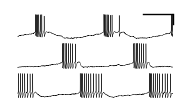

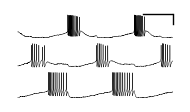

In [44]:
plot_overall_efficient(1)
plt.savefig(PANEL_NEW_F1, facecolor='None', transparent=True)
plot_overall_efficient(2)
plt.savefig(PANEL_NEW_F2, facecolor='None', transparent=True)

In [45]:
def plot_overall_energies(index, labels=True):
    energies = min_energy_x.iloc[index]
    energy1 = energies["energies"].to_numpy()/10/1000
    
    summed_energies_total1 = np.sum(np.asarray(energy1))
    
    with mpl.rc_context(fname='../../../.matplotlibrc'):
        fig, ax = plt.subplots(1, 1, figsize=(1, 0.8))
        ax.bar(range(4), [*energy1, summed_energies_total1], width=0.45, color=["#3182bd", "#fc8d59", "#2ca25f", "k"])
        ax.set_xticks(range(4))
        if labels:
            ax.set_xticklabels(["AB/PD", "LP", "PY", "Sum"], rotation=60)
            ax.set_xlabel("Energy cost")
        else:
            ax.set_xticks([])
        ax.set_ylim([0, 4.0])
        
    return summed_energies_total1

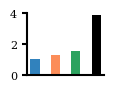

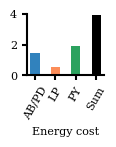

In [46]:
plot_overall_energies(1, labels=False)
plt.savefig(PANEL_NEW_G1, facecolor='None', transparent=True)
plot_overall_energies(2)
plt.savefig(PANEL_NEW_G2, facecolor='None', transparent=True)

# Plot 31 posterior with constraints on total energy consumption

In [47]:
labels_ = get_labels_8pt()

In [48]:
lims=limits.numpy()

In [49]:
from decimal import Decimal
all_labels = []
for dim_i in range(31):
    if dim_i > 31 - 7.5: # synapses
        if dim_i == 24: all_labels.append([r'$\mathdefault{0.01}\;\;\;\;\;\;\;$         ', r'$\mathdefault{10000}\;\;\;\;\;\;$    '])
        else: all_labels.append([r'$\;\;\mathdefault{0.01}\;\;\;\;\;$       ', r'$\mathdefault{1000}\;\;\;\;\;$  '])
    else: # membrane conductances
        num_after_digits = -int(np.log10(lims[dim_i, 1]))
        if num_after_digits > 2:
            num_after_digits=2
        labels = [round((lims[dim_i, num_tmp]), num_after_digits) if lims[dim_i, num_tmp] < 1.0 else int(lims[dim_i, num_tmp])
                  for num_tmp in range(2)]
        new_labels = []
        counter=0
        for l in labels:
            if counter == 0:
                new_labels.append(r'$\mathdefault{'+str(l)+'}\;\;\;$      ')
            else:
                new_labels.append(r'$\mathdefault{'+str(l)+'}\;\;\;$   ')
            counter+=1
        all_labels.append(new_labels)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Arial, sans-serif
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Arial, sans-serif
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Arial, sans-serif


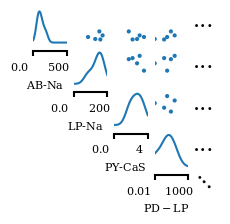

In [50]:
import matplotlib.patheffects as pe

with mpl.rc_context(fname='../../../.matplotlibrc'):

    labels_ = get_labels_8pt()
    new_labels = []
    for l in labels_:
        new_labels.append(l+'    '+r'$\;\;$')
    labels_ = new_labels
    labels_[9] += ''

    fig, axes = pairplot(
        samples=min_energy_theta,
        subset=[0,8,18,25],
        labelpad=1,
        tick_labelpad=1,
        limits=limits,
        ticks=limits,
        tick_labels=all_labels,
        figsize=(2.0, 2.0),
        labels=labels_,
        scatter_offdiag={'rasterized':True, 'alpha':1.0},
        diag=['kde'],
        upper=['scatter'],
        hist_offdiag={'bins':50},
        plot_offdiag={'linewidth': 1.6, 'path_effects':[pe.Stroke(linewidth=2.4, foreground='k'), pe.Normal()]}
    )
    plt.savefig(PANEL_NEW_A, facecolor='None', transparent=True)

### Repeat same analysis for AB/PD neuron

In [51]:
energies_tt = torch.as_tensor(energies.to_numpy())
x_tt = torch.as_tensor(x_np, dtype=torch.float32)

summed_energies = x['energies'].to_numpy()[:, 0] / 10 / 1000

In [52]:
inds = np.argsort(summed_energies)
sorted_energies = summed_energies[inds]
num_vals = sorted_energies.shape[0]
one_percent_quantile = int(num_vals * quantile)
ninenine_percent_quantile = int(num_vals * (1-quantile))
one_percent_energy = sorted_energies[one_percent_quantile]
ninenine_percent_energy = sorted_energies[ninenine_percent_quantile]

min_energy_condition = summed_energies < one_percent_energy
max_energy_condition = summed_energies > ninenine_percent_energy

min_energy_theta = theta_np[min_energy_condition]
max_energy_theta = theta_np[max_energy_condition]

min_energy_energies = summed_energies[min_energy_condition]
max_energy_energies = summed_energies[max_energy_condition]

min_energy_theta = theta_np[min_energy_condition]
max_energy_theta = theta_np[max_energy_condition]

min_energy_energies = summed_energies[min_energy_condition]
max_energy_energies = summed_energies[max_energy_condition]

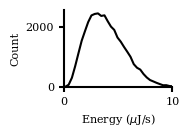

In [53]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1,1, figsize=(1.4, 1.0))
    vals, xvals = np.histogram(summed_energies, bins=100, range=[0, 30])
    val_dist = xvals[1] - xvals[0]
    ax.plot(xvals[1:] - val_dist/2, vals, c='k')
    _ = ax.hist(min_energy_energies, bins=100, range=[0, 30], color='#fd8d3c')
    _ = ax.hist(max_energy_energies, bins=100, range=[0, 30], color='#bd0026')
    ax.set_xlabel("Energy ($\mu$J/s)")
    ax.set_ylabel("Count")
    ax.set_xlim([0, 10])
    ax.set_xticks([0, 10])

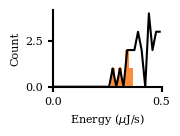

In [54]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1,1, figsize=(1.4, 1.0))
    vals, xvals = np.histogram(summed_energies, bins=30, range=[0, 0.5])
    val_dist = xvals[1] - xvals[0]
    ax.plot(xvals[1:] - val_dist/2, vals, c='k')
    _ = ax.hist(min_energy_energies, bins=30, range=[0, 0.5], color='#fd8d3c')
    _ = ax.hist(max_energy_energies, bins=30, range=[0, 0.5], color='#bd0026')
    ax.set_xlabel("Energy ($\mu$J/s)")
    ax.set_ylabel("Count")
    ax.set_xlim([0,0.5])
    ax.set_xticks([0, 0.5])
    plt.savefig(PANEL_NEW_supp_a1, facecolor='None', transparent=True)

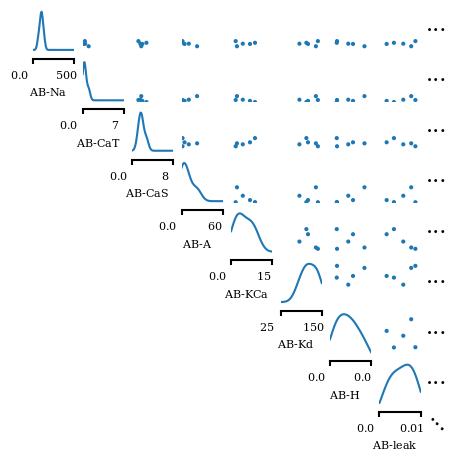

In [55]:
import matplotlib.patheffects as pe

with mpl.rc_context(fname='../../../.matplotlibrc'):

    labels_ = get_labels_8pt()
    new_labels = []
    for l in labels_:
        new_labels.append(l+'    '+r'$\;\;$')
    labels_ = new_labels
    labels_[9] += ''

    fig, axes = pairplot(
        samples=min_energy_theta,
        subset=[0,1,2,3,4,5,6,7],
        labelpad=1,
        tick_labelpad=1,
        limits=limits,
        ticks=limits,
        tick_labels=all_labels,
        figsize=(5, 5),
        labels=labels_,
        scatter_offdiag={'rasterized':True, 'alpha':1.0},
        diag=['kde'],
        upper=['scatter'],
        hist_offdiag={'bins':50},
        plot_offdiag={'linewidth': 1.6, 'path_effects':[pe.Stroke(linewidth=2.4, foreground='k'), pe.Normal()]}
    )
    plt.savefig(PANEL_NEW_supp_b1, facecolor='None', transparent=True)

### Same for LP

In [56]:
energies_tt = torch.as_tensor(energies.to_numpy())
x_tt = torch.as_tensor(x_np, dtype=torch.float32)

summed_energies = x['energies'].to_numpy()[:, 1] / 10 / 1000

In [57]:
inds = np.argsort(summed_energies)
sorted_energies = summed_energies[inds]
num_vals = sorted_energies.shape[0]
one_percent_quantile = int(num_vals * quantile)
ninenine_percent_quantile = int(num_vals * (1-quantile))
one_percent_energy = sorted_energies[one_percent_quantile]
ninenine_percent_energy = sorted_energies[ninenine_percent_quantile]

min_energy_condition = summed_energies < one_percent_energy
max_energy_condition = summed_energies > ninenine_percent_energy

min_energy_theta = theta_np[min_energy_condition]
max_energy_theta = theta_np[max_energy_condition]

min_energy_energies = summed_energies[min_energy_condition]
max_energy_energies = summed_energies[max_energy_condition]

min_energy_theta = theta_np[min_energy_condition]
max_energy_theta = theta_np[max_energy_condition]

min_energy_energies = summed_energies[min_energy_condition]
max_energy_energies = summed_energies[max_energy_condition]

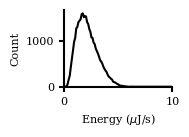

In [58]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1,1, figsize=(1.4, 1.0))
    vals, xvals = np.histogram(summed_energies, bins=100, range=[0, 10])
    val_dist = xvals[1] - xvals[0]
    ax.plot(xvals[1:] - val_dist/2, vals, c='k')
    _ = ax.hist(min_energy_energies, bins=100, range=[0, 10], color='#fd8d3c')
    _ = ax.hist(max_energy_energies, bins=100, range=[0, 10], color='#bd0026')
    ax.set_xlabel("Energy ($\mu$J/s)")
    ax.set_ylabel("Count")
    ax.set_xlim([0, 10])
    ax.set_xticks([0, 10])

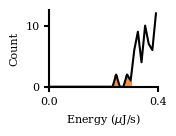

In [59]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1,1, figsize=(1.4, 1.0))
    vals, xvals = np.histogram(summed_energies, bins=30, range=[0, 0.4])
    val_dist = xvals[1] - xvals[0]
    ax.plot(xvals[1:] - val_dist/2, vals, c='k')
    _ = ax.hist(min_energy_energies, bins=30, range=[0, 0.4], color='#fd8d3c')
    _ = ax.hist(max_energy_energies, bins=30, range=[0, 0.4], color='#bd0026')
    ax.set_xlabel("Energy ($\mu$J/s)")
    ax.set_ylabel("Count")
    ax.set_xlim([0, 0.4])
    ax.set_xticks([0, 0.4])
    plt.savefig(PANEL_NEW_supp_a2, facecolor='None', transparent=True)

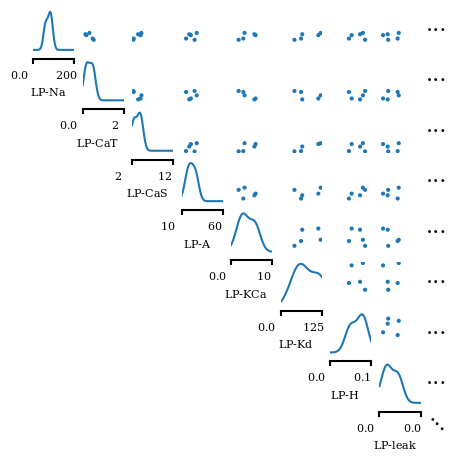

In [60]:
import matplotlib.patheffects as pe

with mpl.rc_context(fname='../../../.matplotlibrc'):

    labels_ = get_labels_8pt()
    new_labels = []
    for l in labels_:
        new_labels.append(l+'    '+r'$\;\;$')
    labels_ = new_labels
    labels_[9] += ''

    fig, axes = pairplot(
        samples=min_energy_theta,
        subset=[8,9,10,11,12,13,14,15],
        labelpad=1,
        tick_labelpad=1,
        limits=limits,
        ticks=limits,
        tick_labels=all_labels,
        figsize=(5, 5),
        labels=labels_,
        scatter_offdiag={'rasterized':True, 'alpha':1.0},
        diag=['kde'],
        upper=['scatter'],
        hist_offdiag={'bins':50},
        plot_offdiag={'linewidth': 1.6, 'path_effects':[pe.Stroke(linewidth=2.4, foreground='k'), pe.Normal()]}
    )
    plt.savefig(PANEL_NEW_supp_b2, facecolor='None', transparent=True)

### Same for PY

In [61]:
energies_tt = torch.as_tensor(energies.to_numpy())
x_tt = torch.as_tensor(x_np, dtype=torch.float32)

summed_energies = x['energies'].to_numpy()[:, 2] / 10 / 1000

In [62]:
inds = np.argsort(summed_energies)
sorted_energies = summed_energies[inds]
num_vals = sorted_energies.shape[0]
one_percent_quantile = int(num_vals * quantile)
ninenine_percent_quantile = int(num_vals * (1-quantile))
one_percent_energy = sorted_energies[one_percent_quantile]
ninenine_percent_energy = sorted_energies[ninenine_percent_quantile]

min_energy_condition = summed_energies < one_percent_energy
max_energy_condition = summed_energies > ninenine_percent_energy

min_energy_theta = theta_np[min_energy_condition]
max_energy_theta = theta_np[max_energy_condition]

min_energy_energies = summed_energies[min_energy_condition]
max_energy_energies = summed_energies[max_energy_condition]

min_energy_theta = theta_np[min_energy_condition]
max_energy_theta = theta_np[max_energy_condition]

min_energy_energies = summed_energies[min_energy_condition]
max_energy_energies = summed_energies[max_energy_condition]

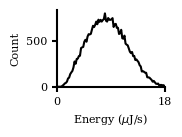

In [63]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1,1, figsize=(1.4, 1.0))
    vals, xvals = np.histogram(summed_energies, bins=100, range=[0, 18])
    val_dist = xvals[1] - xvals[0]
    ax.plot(xvals[1:] - val_dist/2, vals, c='k')
    _ = ax.hist(min_energy_energies, bins=100, range=[0, 18], color='#fd8d3c')
    _ = ax.hist(max_energy_energies, bins=100, range=[0, 18], color='#bd0026')
    ax.set_xlabel("Energy ($\mu$J/s)")
    ax.set_ylabel("Count")
    ax.set_xlim([0, 18])
    ax.set_xticks([0, 18])

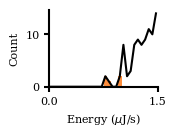

In [64]:
with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1,1, figsize=(1.4, 1.0))
    vals, xvals = np.histogram(summed_energies, bins=30, range=[0, 1.5])
    val_dist = xvals[1] - xvals[0]
    ax.plot(xvals[1:] - val_dist/2, vals, c='k')
    _ = ax.hist(min_energy_energies, bins=30, range=[0, 1.5], color='#fd8d3c')
    _ = ax.hist(max_energy_energies, bins=30, range=[0, 1.5], color='#bd0026')
    ax.set_xlabel("Energy ($\mu$J/s)")
    ax.set_ylabel("Count")
    ax.set_xlim([0, 1.5])
    ax.set_xticks([0, 1.5])
    plt.savefig(PANEL_NEW_supp_a3, facecolor='None', transparent=True)

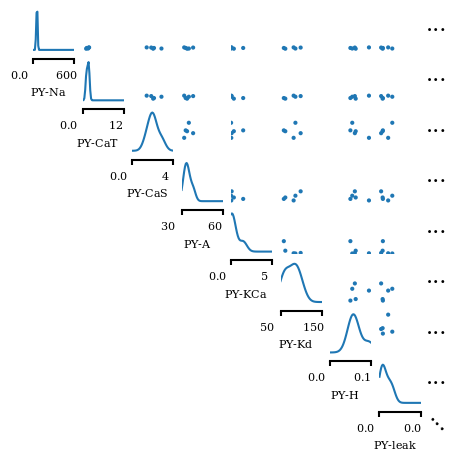

In [65]:
import matplotlib.patheffects as pe

with mpl.rc_context(fname='../../../.matplotlibrc'):

    labels_ = get_labels_8pt()
    new_labels = []
    for l in labels_:
        new_labels.append(l+'    '+r'$\;\;$')
    labels_ = new_labels
    labels_[9] += ''

    fig, axes = pairplot(
        samples=min_energy_theta,
        subset=[16,17,18,19,20,21,22,23],
        labelpad=1,
        tick_labelpad=1,
        limits=limits,
        ticks=limits,
        tick_labels=all_labels,
        figsize=(5, 5),
        labels=labels_,
        scatter_offdiag={'rasterized':True, 'alpha':1.0},
        diag=['kde'],
        upper=['scatter'],
        hist_offdiag={'bins':50},
        plot_offdiag={'linewidth': 1.6, 'path_effects':[pe.Stroke(linewidth=2.4, foreground='k'), pe.Normal()]}
    )
    plt.savefig(PANEL_NEW_supp_b3, facecolor='None', transparent=True)

# For the 7 best performing circuits of each model separately, find two that differ really strongly in their parameters

### AB/PD

In [66]:
quantile = 0.00015

In [67]:
energies_tt = torch.as_tensor(energies.to_numpy())
x_tt = torch.as_tensor(x_np, dtype=torch.float32)

summed_energies = x['energies'].to_numpy()[:, 0] / 10 / 1000

In [68]:
inds = np.argsort(summed_energies)
sorted_energies = summed_energies[inds]
num_vals = sorted_energies.shape[0]
one_percent_quantile = int(num_vals * quantile)
ninenine_percent_quantile = int(num_vals * (1-quantile))
one_percent_energy = sorted_energies[one_percent_quantile]
ninenine_percent_energy = sorted_energies[ninenine_percent_quantile]

min_energy_condition = summed_energies < one_percent_energy
min_energy_theta_abpd = theta_np[min_energy_condition]
min_energy_seed_abpd = seeds[min_energy_condition]
min_energy_energies = summed_energies[min_energy_condition]

In [69]:
# counter = 0
# for see, t in zip(min_energy_seed_abpd, min_energy_theta_abpd):
#     print(counter)
#     circuit_params = np.asarray([t])
#     theta_pd = pd.DataFrame(circuit_params, columns=theta.columns)
#     out_target = simulate(
#         theta_pd.loc[0], seed=int(see), track_energy=True, track_currents=True
#     )
#     show_traces(out_target)
#     plt.show()
#     counter += 1

In [70]:
selected_inds_ab = [1, 3, 7, 8, 16]

In [71]:
# print(min_energy_theta_abpd[selected_inds_ab])

In [72]:
selections_of_pairs_ab = [[], []]

### LP

In [73]:
energies_tt = torch.as_tensor(energies.to_numpy())
x_tt = torch.as_tensor(x_np, dtype=torch.float32)

summed_energies = x['energies'].to_numpy()[:, 1] / 10 / 1000

In [74]:
inds = np.argsort(summed_energies)
sorted_energies = summed_energies[inds]
num_vals = sorted_energies.shape[0]
one_percent_quantile = int(num_vals * quantile)
ninenine_percent_quantile = int(num_vals * (1-quantile))
one_percent_energy = sorted_energies[one_percent_quantile]
ninenine_percent_energy = sorted_energies[ninenine_percent_quantile]

min_energy_condition = summed_energies < one_percent_energy
min_energy_theta_lp = theta_np[min_energy_condition]
min_energy_seed_lp = seeds[min_energy_condition]
min_energy_energies = summed_energies[min_energy_condition]

In [75]:
# counter = 0
# for see, t in zip(min_energy_seed_lp, min_energy_theta_lp):
#     print(counter)
#     circuit_params = np.asarray([t])
#     theta_pd = pd.DataFrame(circuit_params, columns=theta.columns)
#     out_target = simulate(
#         theta_pd.loc[0], seed=int(see), track_energy=True, track_currents=True
#     )
#     show_traces(out_target)
#     plt.show()
#     counter += 1

In [76]:
selected_inds_lp = [0, 3, 4, 7, 13]

In [77]:
# print(min_energy_theta_lp[selected_inds_lp])

In [78]:
selections_of_pairs_lp = [[], []]

### PY

In [79]:
energies_tt = torch.as_tensor(energies.to_numpy())
x_tt = torch.as_tensor(x_np, dtype=torch.float32)

summed_energies = x['energies'].to_numpy()[:, 2] / 10 / 1000

In [80]:
inds = np.argsort(summed_energies)
sorted_energies = summed_energies[inds]
num_vals = sorted_energies.shape[0]
one_percent_quantile = int(num_vals * quantile)
ninenine_percent_quantile = int(num_vals * (1-quantile))
one_percent_energy = sorted_energies[one_percent_quantile]
ninenine_percent_energy = sorted_energies[ninenine_percent_quantile]

min_energy_condition = summed_energies < one_percent_energy
min_energy_theta_py = theta_np[min_energy_condition]
min_energy_seed_py = seeds[min_energy_condition]
min_energy_energies = summed_energies[min_energy_condition]

In [81]:
# counter = 0
# for see, t in zip(min_energy_seed_py, min_energy_theta_py):
#     print(counter)
#     circuit_params = np.asarray([t])
#     theta_pd = pd.DataFrame(circuit_params, columns=theta.columns)
#     out_target = simulate(
#         theta_pd.loc[0], seed=int(see), track_energy=True, track_currents=True
#     )
#     show_traces(out_target)
#     plt.show()
#     counter += 1

In [82]:
selected_inds_py = [0, 1, 5, 12]

In [83]:
# print(min_energy_theta_py[selected_inds_py])

In [84]:
selections_of_pairs_py = [[], []]

### Run MCMC all combinations...

In [85]:
xo

array([1.17085859e+03, 2.06036434e+02, 2.14307031e+02, 4.12842187e+02,
       1.75970382e-01, 1.83034085e-01, 3.52597820e-01, 4.11600328e-01,
       6.30544893e-01, 4.81925781e+02, 2.56353125e+02, 2.75164844e+02,
       4.20460938e+01, 2.35011166e-01, 3.59104797e-02, 2.50000000e+00,
       2.50000000e+00, 2.50000000e+00])

### Simulate the best simulation for each scenario

In [94]:
allowed_std = 1.0

In [95]:
selected_inds_ab = range(5)
selected_inds_lp = range(5)
selected_inds_py = range(5)

In [96]:
def load_theta_x_seeds(pair_ab, pair_lp, pair_py):
    all_stats_loaded = []
    all_seeds_loaded = []
    for k in range(4):
        stats_loaded = pd.read_pickle(f"simulated_samples_{pair_ab}_{pair_lp}_{pair_py}_{k}.pkl")
        seeds_loaded = np.load(f"seeds_for_simulating_mcmc.npy")
        all_stats_loaded.append(stats_loaded)
        all_seeds_loaded.append(seeds_loaded)
    all_stats_loaded = np.concatenate(all_stats_loaded)
    all_seeds_loaded = np.concatenate(all_seeds_loaded)
    samples = np.load(f"mcmc_samples_{pair_ab}_{pair_lp}_{pair_py}.npy")
    
    return samples, all_stats_loaded, all_seeds_loaded

In [97]:
def load_x_pd(pair_ab, pair_lp, pair_py):
    all_stats_loaded = []
    for k in range(4):
        stats_loaded = pd.read_pickle(f"simulated_samples_{pair_ab}_{pair_lp}_{pair_py}_{k}.pkl")
        all_stats_loaded.append(stats_loaded)
    all_stats_loaded = pd.concat(all_stats_loaded)
    
    return all_stats_loaded

Pair =====  0 0 0
no good one found...
Pair =====  0 0 1
no good one found...
Pair =====  0 0 2
no good one found...
Pair =====  0 0 3
Success! Summary stats: [1.23284286e+03 2.05668750e+02 1.78581250e+02 3.98550000e+02
 1.66824789e-01 1.44853214e-01 3.23277211e-01 4.32096548e-01
 6.20650297e-01 5.32707143e+02 2.32457143e+02 3.24239286e+02
 4.81035714e+01 2.63001309e-01 3.90184127e-02 2.50000000e+00
 2.50000000e+00 2.50000000e+00]
Energy consumption PM     3009.069408
LP     4380.263926
PY    11798.915736
Name: 0, dtype: float64


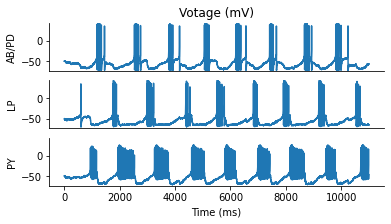

Pair =====  0 0 4
no good one found...
Pair =====  0 1 0
no good one found...
Pair =====  0 1 1
Success! Summary stats: [1.15396429e+03 2.10121875e+02 2.13155556e+02 4.03669444e+02
 1.82086983e-01 1.84715903e-01 3.49811038e-01 3.93311875e-01
 6.25588809e-01 4.53867857e+02 2.68039286e+02 2.53160714e+02
 3.14964286e+01 2.19383492e-01 2.72941104e-02 2.50000000e+00
 2.50000000e+00 2.50000000e+00]
Energy consumption PM    2846.307704
LP    5774.015027
PY    9125.010872
Name: 0, dtype: float64


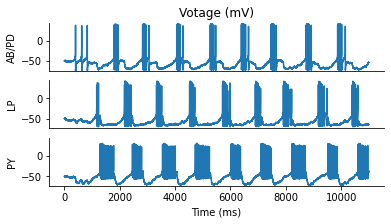

Pair =====  0 1 2
no good one found...
Pair =====  0 1 3
Success! Summary stats: [1.28089643e+03 2.00037500e+02 2.15562500e+02 3.73994444e+02
 1.56169926e-01 1.68290344e-01 2.91978677e-01 4.45929330e-01
 6.39348559e-01 5.71189286e+02 2.47750000e+02 3.77089286e+02
 3.40321429e+01 2.94394830e-01 2.65690044e-02 2.50000000e+00
 2.50000000e+00 2.50000000e+00]
Energy consumption PM     2850.126213
LP     6016.398177
PY    11493.935918
Name: 0, dtype: float64


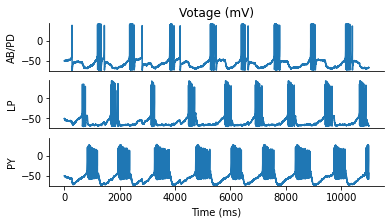

Pair =====  0 1 4
no good one found...
Pair =====  0 2 0
Success! Summary stats: [1.21017500e+03 2.08890625e+02 2.13792857e+02 4.08165625e+02
 1.72611916e-01 1.76662761e-01 3.37278183e-01            nan
            nan            nan            nan            nan
            nan            nan            nan 2.50000000e+00
 2.50000000e+00 2.50000000e+00]
Energy consumption PM    3044.587618
LP    5356.946307
PY    6269.338221
Name: 0, dtype: float64


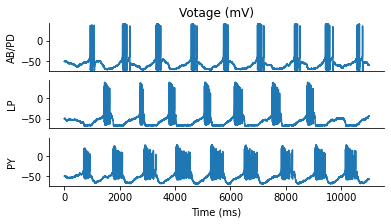

Pair =====  0 2 1
no good one found...
Pair =====  0 2 2
no good one found...
Pair =====  0 2 3
no good one found...
Pair =====  0 2 4
no good one found...
Pair =====  0 3 0
Success! Summary stats: [1.20824643e+03 2.17556250e+02 1.96459375e+02 3.84855556e+02
 1.80059502e-01 1.62598763e-01 3.18524058e-01 4.24233467e-01
 6.37760154e-01 5.12578571e+02 2.57992857e+02 2.82953571e+02
 6.17178571e+01 2.34185316e-01 5.10805211e-02 2.50000000e+00
 2.50000000e+00 2.50000000e+00]
Energy consumption PM    2697.853330
LP    4654.745697
PY    8639.674452
Name: 0, dtype: float64


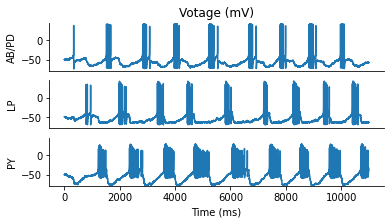

Pair =====  0 3 1
no good one found...
Pair =====  0 3 2
no good one found...
Pair =====  0 3 3
Success! Summary stats: [1.17106429e+03 2.28462500e+02 2.18730556e+02 4.18293750e+02
 1.95089632e-01 1.86779290e-01 3.57191108e-01 3.95906654e-01
 6.36679699e-01 4.63632143e+02 2.81960714e+02 2.42707143e+02
 4.44607143e+01 2.07253475e-01 3.79660748e-02 2.50000000e+00
 2.50000000e+00 2.50000000e+00]
Energy consumption PM     2792.250479
LP     5933.992606
PY    12304.436142
Name: 0, dtype: float64


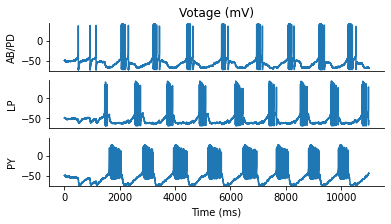

Pair =====  0 3 4
no good one found...
Pair =====  0 4 0
no good one found...
Pair =====  0 4 1
no good one found...
Pair =====  0 4 2
no good one found...
Pair =====  0 4 3
Success! Summary stats: [1.23554286e+03 1.99525000e+02 2.21684375e+02 4.58928125e+02
 1.61487721e-01 1.79422651e-01 3.71438451e-01 3.60171353e-01
 6.00707613e-01 4.45007143e+02 2.97192857e+02 2.39450000e+02
 7.58357143e+01 1.93801452e-01 6.13784571e-02 2.50000000e+00
 2.50000000e+00 2.50000000e+00]
Energy consumption PM     3037.808235
LP     7391.436010
PY    11348.370191
Name: 0, dtype: float64


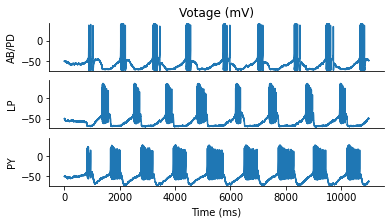

Pair =====  0 4 4
no good one found...
Pair =====  1 0 0
no good one found...
Pair =====  1 0 1
no good one found...
Pair =====  1 0 2
no good one found...
Pair =====  1 0 3
no good one found...
Pair =====  1 0 4
no good one found...
Pair =====  1 1 0
no good one found...
Pair =====  1 1 1
Success! Summary stats: [1.16792500e+03 1.96338889e+02 1.95658333e+02 3.58941667e+02
 1.68109158e-01 1.67526454e-01 3.07332805e-01 3.92199306e-01
 6.24793972e-01 4.58059375e+02 2.71653125e+02 2.63609375e+02
 5.70781250e+01 2.25707451e-01 4.88713959e-02 2.50000000e+00
 2.50000000e+00 2.50000000e+00]
Energy consumption PM    4153.816234
LP    5621.485495
PY    8694.116158
Name: 0, dtype: float64


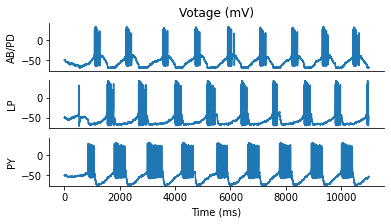

Pair =====  1 1 2
no good one found...
Pair =====  1 1 3
Success! Summary stats: [1.17557500e+03 1.96222222e+02 1.74275000e+02 3.72622222e+02
 1.66915954e-01 1.48246603e-01 3.16970182e-01 4.24906429e-01
 6.35159922e-01 4.99509375e+02 2.47168750e+02 3.07953125e+02
 7.28937500e+01 2.61959573e-01 6.20068902e-02 2.50000000e+00
 2.50000000e+00 2.50000000e+00]
Energy consumption PM     4143.877016
LP     5931.147924
PY    11097.269573
Name: 0, dtype: float64


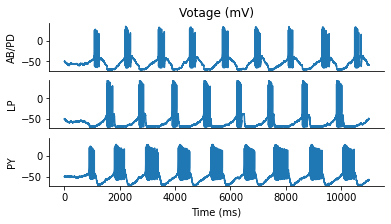

Pair =====  1 1 4
no good one found...
Pair =====  1 2 0
Success! Summary stats: [1.18378750e+03 1.69263889e+02 1.92615625e+02 3.89261111e+02
 1.42985028e-01 1.62711319e-01 3.28826847e-01 4.04530479e-01
 6.16538019e-01 4.78878125e+02 2.50971875e+02 3.05912500e+02
 5.83562500e+01 2.58418424e-01 4.92962208e-02 2.50000000e+00
 2.50000000e+00 2.50000000e+00]
Energy consumption PM    4070.40597
LP    7098.26958
PY    8654.83557
Name: 0, dtype: float64


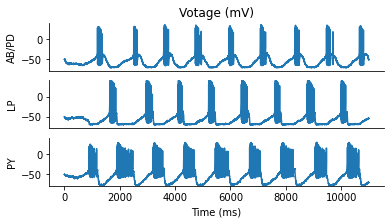

Pair =====  1 2 1
no good one found...
Pair =====  1 2 2
no good one found...
Pair =====  1 2 3
Success! Summary stats: [1.14101429e+03 1.80796875e+02 2.12015625e+02 4.20083333e+02
 1.58452771e-01 1.85813296e-01 3.68166585e-01 4.06386548e-01
 6.13774086e-01 4.63692857e+02 2.36632143e+02 2.90217857e+02
 2.68678571e+01 2.54350766e-01 2.35473451e-02 2.50000000e+00
 2.50000000e+00 2.50000000e+00]
Energy consumption PM     3517.845165
LP     6933.102115
PY    12048.460169
Name: 0, dtype: float64


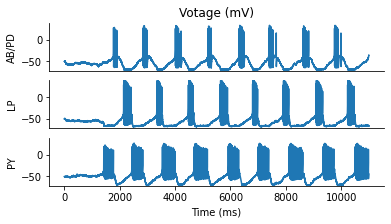

Pair =====  1 2 4
no good one found...
Pair =====  1 3 0
no good one found...
Pair =====  1 3 1
no good one found...
Pair =====  1 3 2
no good one found...
Pair =====  1 3 3
Success! Summary stats: [1.12648125e+03 1.85588889e+02 1.90377778e+02 2.93265000e+02
 1.64750979e-01 1.69002172e-01 2.60337223e-01 4.24790692e-01
 6.83106132e-01 4.78518750e+02 2.90987500e+02 2.95140625e+02
 9.62562500e+01 2.62002253e-01 8.54486038e-02 2.50000000e+00
 2.50000000e+00 2.50000000e+00]
Energy consumption PM     3639.443374
LP     6072.215622
PY    10719.267828
Name: 0, dtype: float64


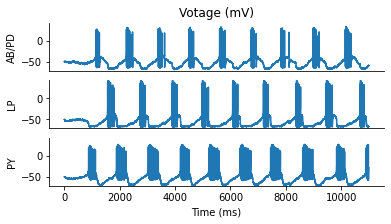

Pair =====  1 3 4
no good one found...
Pair =====  1 4 0
Success! Summary stats: [1.16859688e+03 2.05363889e+02 1.82725000e+02 3.75828125e+02
 1.75735442e-01 1.56362732e-01 3.21606307e-01 4.23555493e-01
 6.21862223e-01 4.94965625e+02 2.31740625e+02 2.89437500e+02
 4.04312500e+01 2.47679509e-01 3.45981158e-02 2.50000000e+00
 2.50000000e+00 2.50000000e+00]
Energy consumption PM    4218.124263
LP    6435.811875
PY    6656.373765
Name: 0, dtype: float64


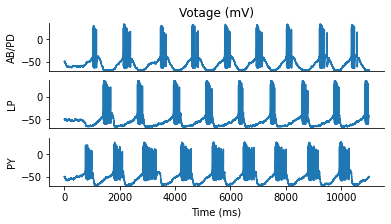

Pair =====  1 4 1
no good one found...
Pair =====  1 4 2
no good one found...
Pair =====  1 4 3
Success! Summary stats: [1.17115000e+03 2.10752778e+02 2.35712500e+02 3.53266667e+02
 1.79953702e-01 2.01265850e-01 3.01640837e-01 4.13591876e-01
 6.98592196e-01 4.84378125e+02 3.33778125e+02 2.79212500e+02
 9.80656250e+01 2.38408829e-01 8.37344704e-02 2.50000000e+00
 2.50000000e+00 2.50000000e+00]
Energy consumption PM    4026.102158
LP    6684.376446
PY    8964.912208
Name: 0, dtype: float64


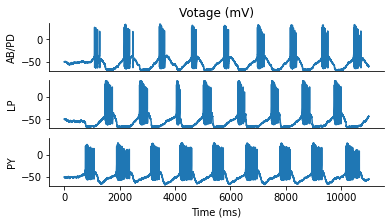

Pair =====  1 4 4
no good one found...
Pair =====  2 0 0
no good one found...
Pair =====  2 0 1
Success! Summary stats: [1.18619688e+03 1.99319444e+02 2.12181250e+02 4.16911111e+02
 1.68032347e-01 1.78875239e-01 3.51468732e-01 4.02583888e-01
 6.18520851e-01 4.77543750e+02 2.56143750e+02 2.60453125e+02
 4.39625000e+01 2.19569896e-01 3.70617230e-02 2.50000000e+00
 2.50000000e+00 2.50000000e+00]
Energy consumption PM    3834.948361
LP    9139.041432
PY    9946.425052
Name: 0, dtype: float64


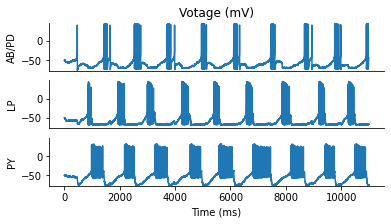

Pair =====  2 0 2
Success! Summary stats: [1.17054643e+03 1.76040625e+02 2.06591667e+02 3.51968750e+02
 1.50391835e-01 1.76491647e-01 3.00687560e-01 4.15199861e-01
 6.48161878e-01 4.86010714e+02 2.72692857e+02 3.08214286e+02
 6.34678571e+01 2.63308040e-01 5.42207089e-02 2.50000000e+00
 2.50000000e+00 2.50000000e+00]
Energy consumption PM    3396.209909
LP    8219.206825
PY    8950.384435
Name: 0, dtype: float64


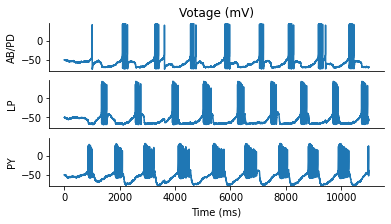

Pair =====  2 0 3
Success! Summary stats: [1.24838571e+03 1.64825000e+02 2.33896875e+02 3.61613889e+02
 1.32030508e-01 1.87359461e-01 2.89665193e-01 4.31525856e-01
 6.49879273e-01 5.38710714e+02 2.72589286e+02 3.69392857e+02
 3.18071429e+01 2.95896415e-01 2.54786181e-02 2.50000000e+00
 2.50000000e+00 2.50000000e+00]
Energy consumption PM    2854.032216
LP    4409.478789
PY    8861.351230
Name: 0, dtype: float64


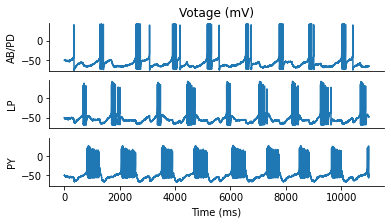

Pair =====  2 0 4
no good one found...
Pair =====  2 1 0
no good one found...
Pair =====  2 1 1
Success! Summary stats: [1.17971562e+03 1.69450000e+02 2.76625000e+02 3.73133333e+02
 1.43636311e-01 2.34484476e-01 3.16290914e-01 3.55326628e-01
 6.41966152e-01 4.19184375e+02 3.38153125e+02 2.50878125e+02
 6.15281250e+01 2.12659831e-01 5.21550480e-02 2.50000000e+00
 2.50000000e+00 2.50000000e+00]
Energy consumption PM    3897.893470
LP    5465.280690
PY    7869.987341
Name: 0, dtype: float64


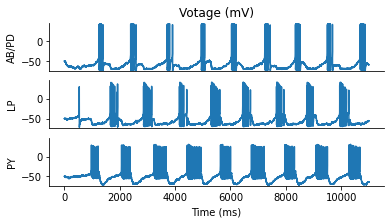

Pair =====  2 1 2
no good one found...
Pair =====  2 1 3
Success! Summary stats: [1.17306429e+03 1.83993750e+02 2.09911111e+02 4.00744444e+02
 1.56848821e-01 1.78942547e-01 3.41621895e-01 3.96811769e-01
 6.18620950e-01 4.65485714e+02 2.60196429e+02 2.75382143e+02
 5.34464286e+01 2.34754520e-01 4.55613808e-02 2.50000000e+00
 2.50000000e+00 2.50000000e+00]
Energy consumption PM     3870.213440
LP     8170.450873
PY    12151.105052
Name: 0, dtype: float64


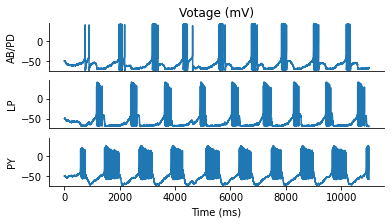

Pair =====  2 1 4
Success! Summary stats: [1.19796071e+03 1.65271875e+02 2.23456250e+02 4.03840625e+02
 1.37961014e-01 1.86530533e-01 3.37106735e-01 3.91486723e-01
 6.31394423e-01 4.68985714e+02 2.87400000e+02 3.03842857e+02
 7.00642857e+01 2.53633407e-01 5.84862967e-02 2.50000000e+00
 2.50000000e+00 2.50000000e+00]
Energy consumption PM    3442.920557
LP    4415.647661
PY    8417.326186
Name: 0, dtype: float64


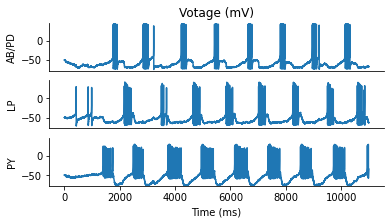

Pair =====  2 2 0
no good one found...
Pair =====  2 2 1
no good one found...
Pair =====  2 2 2
no good one found...
Pair =====  2 2 3
no good one found...
Pair =====  2 2 4
no good one found...
Pair =====  2 3 0
no good one found...
Pair =====  2 3 1
no good one found...
Pair =====  2 3 2
no good one found...
Pair =====  2 3 3
no good one found...
Pair =====  2 3 4
no good one found...
Pair =====  2 4 0
no good one found...
Pair =====  2 4 1
no good one found...
Pair =====  2 4 2
no good one found...
Pair =====  2 4 3
no good one found...
Pair =====  2 4 4
no good one found...
Pair =====  3 0 0
no good one found...
Pair =====  3 0 1
no good one found...
Pair =====  3 0 2
no good one found...
Pair =====  3 0 3
Success! Summary stats: [1.19760625e+03 1.92066667e+02 2.11537500e+02 4.32605556e+02
 1.60375471e-01 1.76633597e-01 3.61225199e-01 3.83319330e-01
 6.07842728e-01 4.59065625e+02 2.68890625e+02 2.60615625e+02
 5.73531250e+01 2.17613782e-01 4.78898010e-02 2.50000000e+00
 2.50000000e

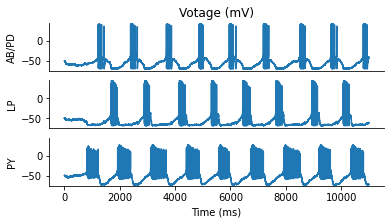

Pair =====  3 0 4
no good one found...
Pair =====  3 1 0
no good one found...
Pair =====  3 1 1
Success! Summary stats: [1.17115313e+03 1.84100000e+02 2.15262500e+02 3.56503125e+02
 1.57195499e-01 1.83803890e-01 3.04403513e-01 4.35105358e-01
 6.63446016e-01 5.09575000e+02 2.67421875e+02 3.10353125e+02
 5.21593750e+01 2.64997905e-01 4.45367680e-02 2.50000000e+00
 2.50000000e+00 2.50000000e+00]
Energy consumption PM    3374.348458
LP    4709.894838
PY    8489.483055
Name: 0, dtype: float64


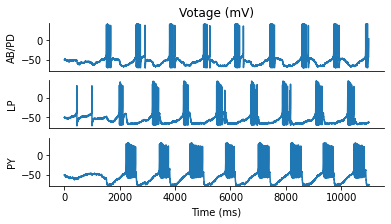

Pair =====  3 1 2
no good one found...
Pair =====  3 1 3
Success! Summary stats: [1.11942188e+03 1.98069444e+02 2.01750000e+02 3.51750000e+02
 1.76939051e-01 1.80226959e-01 3.14224697e-01 4.24943121e-01
 6.62551819e-01 4.75690625e+02 2.65984375e+02 2.75668750e+02
 6.13218750e+01 2.46259928e-01 5.47799506e-02 2.50000000e+00
 2.50000000e+00 2.50000000e+00]
Energy consumption PM     4194.536082
LP     7225.492098
PY    11647.502327
Name: 0, dtype: float64


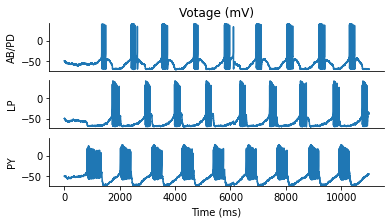

Pair =====  3 1 4
no good one found...
Pair =====  3 2 0
no good one found...
Pair =====  3 2 1
no good one found...
Pair =====  3 2 2
no good one found...
Pair =====  3 2 3
Success! Summary stats: [1.21363571e+03 1.93153125e+02 2.08268750e+02 4.29009375e+02
 1.59152473e-01 1.71607302e-01 3.53491060e-01 4.05458216e-01
 6.21950574e-01 4.92078571e+02 2.62742857e+02 2.96485714e+02
 5.20071429e+01 2.44295476e-01 4.28523504e-02 2.50000000e+00
 2.50000000e+00 2.50000000e+00]
Energy consumption PM     3080.825844
LP     3675.192364
PY    11210.534157
Name: 0, dtype: float64


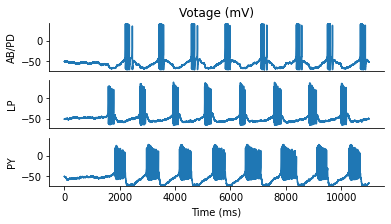

Pair =====  3 2 4
no good one found...
Pair =====  3 3 0
no good one found...
Pair =====  3 3 1
Success! Summary stats: [1.13835000e+03 1.75833333e+02 2.23687500e+02 2.76145833e+02
 1.54463331e-01 1.96501515e-01 2.42584296e-01 4.05789081e-01
 6.94685290e-01 4.61930000e+02 3.28865000e+02 2.81310000e+02
 8.03600000e+01 2.47120833e-01 7.05934027e-02 2.50000000e+00
 2.50000000e+00 2.50000000e+00]
Energy consumption PM    2323.592597
LP    3223.655325
PY    4610.751217
Name: 0, dtype: float64


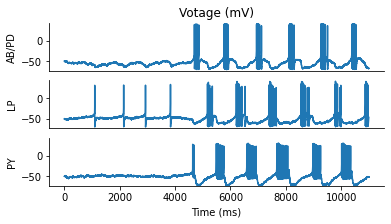

Pair =====  3 3 2
no good one found...
Pair =====  3 3 3
Success! Summary stats: [1.17868929e+03 2.00715625e+02 2.11421875e+02 3.84412500e+02
 1.70287138e-01 1.79370321e-01 3.26135568e-01 3.96293704e-01
 6.45653616e-01 4.67107143e+02 2.93917857e+02 2.60635714e+02
 7.52250000e+01 2.21123342e-01 6.38208906e-02 2.50000000e+00
 2.50000000e+00 2.50000000e+00]
Energy consumption PM     3115.064989
LP     5176.358572
PY    11043.500551
Name: 0, dtype: float64


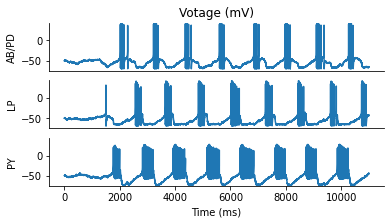

Pair =====  3 3 4
no good one found...
Pair =====  3 4 0
no good one found...
Pair =====  3 4 1
no good one found...
Pair =====  3 4 2
no good one found...
Pair =====  3 4 3
no good one found...
Pair =====  3 4 4
no good one found...
Pair =====  4 0 0
no good one found...
Pair =====  4 0 1
no good one found...
Pair =====  4 0 2
no good one found...
Pair =====  4 0 3
Success! Summary stats: [1.21478214e+03 1.91137500e+02 2.20753125e+02 4.01283333e+02
 1.57343027e-01 1.81722399e-01 3.30333579e-01 3.84275252e-01
 6.34373006e-01 4.66810714e+02 3.03814286e+02 2.66032143e+02
 8.07071429e+01 2.18995763e-01 6.64375447e-02 2.50000000e+00
 2.50000000e+00 2.50000000e+00]
Energy consumption PM     2551.756857
LP     6473.236481
PY    13541.800905
Name: 0, dtype: float64


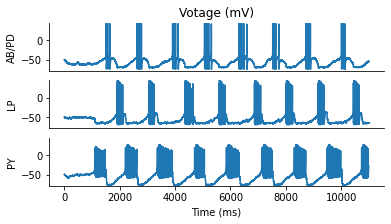

Pair =====  4 0 4
no good one found...
Pair =====  4 1 0
no good one found...
Pair =====  4 1 1
Success! Summary stats: [1.16355312e+03 1.47658333e+02 2.08121875e+02 4.01836111e+02
 1.26902958e-01 1.78867531e-01 3.45352612e-01 3.70129748e-01
 6.22352869e-01 4.30665625e+02 2.93475000e+02 2.83484375e+02
 8.53531250e+01 2.43636813e-01 7.33555892e-02 2.50000000e+00
 2.50000000e+00 2.50000000e+00]
Energy consumption PM    2759.628868
LP    5682.717873
PY    8795.435678
Name: 0, dtype: float64


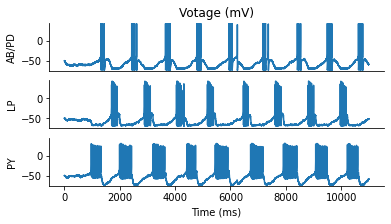

Pair =====  4 1 2
no good one found...
Pair =====  4 1 3
Success! Summary stats: [1.19793750e+03 2.00127778e+02 1.99237500e+02 4.08397222e+02
 1.67060283e-01 1.66317108e-01 3.40916970e-01 3.94628789e-01
 6.13244117e-01 4.72740625e+02 2.61887500e+02 2.68806250e+02
 6.26500000e+01 2.24390880e-01 5.22982209e-02 2.50000000e+00
 2.50000000e+00 2.50000000e+00]
Energy consumption PM     2929.209132
LP     5831.821012
PY    12487.354923
Name: 0, dtype: float64


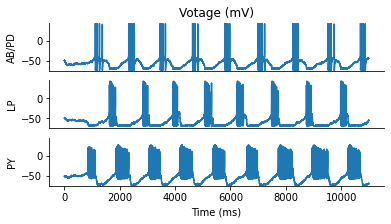

Pair =====  4 1 4
no good one found...
Pair =====  4 2 0
no good one found...
Pair =====  4 2 1
no good one found...
Pair =====  4 2 2
no good one found...
Pair =====  4 2 3
no good one found...
Pair =====  4 2 4
no good one found...
Pair =====  4 3 0
no good one found...
Pair =====  4 3 1
no good one found...
Pair =====  4 3 2
no good one found...
Pair =====  4 3 3
Success! Summary stats: [1.16995000e+03 2.03053125e+02 2.11716667e+02 3.49847222e+02
 1.73557096e-01 1.80962149e-01 2.99027499e-01 3.94284249e-01
 6.47387251e-01 4.61292857e+02 2.96117857e+02 2.51550000e+02
 8.91000000e+01 2.15009188e-01 7.61571007e-02 2.50000000e+00
 2.50000000e+00 2.50000000e+00]
Energy consumption PM    2754.078244
LP    7389.213052
PY    9779.745828
Name: 0, dtype: float64


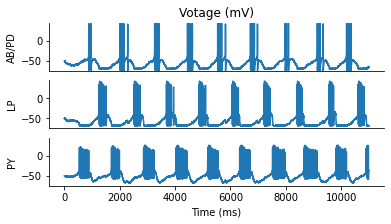

Pair =====  4 3 4
no good one found...
Pair =====  4 4 0
no good one found...
Pair =====  4 4 1
no good one found...
Pair =====  4 4 2
no good one found...
Pair =====  4 4 3
no good one found...
Pair =====  4 4 4
no good one found...


In [98]:
successful_samples_tt = []
for pair_ab in selected_inds_ab:
    for pair_lp in selected_inds_lp:
        for pair_py in selected_inds_py:
            print("Pair ===== ", pair_ab, pair_lp, pair_py)
            samples, all_stats_loaded, all_seeds_loaded = load_theta_x_seeds(pair_ab, pair_lp, pair_py)
            close_sim = check_if_close_to_obs(all_stats_loaded, sloppiness_durations=allowed_std, sloppiness_phases=allowed_std)
            
            if np.any(close_sim):
                successful_samples = samples[close_sim]
                successful_samples_tt.append(torch.as_tensor(successful_samples[0], dtype=torch.float32))
                successful_seeds = all_seeds_loaded[close_sim]
#                 print("posterior log_prob", posterior.log_prob(successful_samples_tt, x=xo))
                trace = simulator(np.concatenate((successful_samples[0], [successful_seeds[0]])))
                stats = summary_stats(trace, stats_customization=custom_stats, t_burn_in=1000).loc[0]
                print("Success! Summary stats:", stats.to_numpy()[:18])
                print("Energy consumption", stats["energies"])
                show_traces(trace)
                plt.show()
            else:
                print("no good one found...")

In [99]:
successful_samples_tt = torch.stack(successful_samples_tt)

### Plot a histogramm over posterior log-probs for later comparison

In [100]:
posterior._sample_with = "rejection"

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

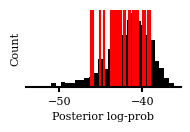

In [101]:
samples = posterior.sample((1000,), x=xo)
log_probs = posterior.log_prob(samples, x=xo).numpy()

probs_of_successful = posterior.log_prob(successful_samples_tt, x=xo).numpy()
with mpl.rc_context(fname='../../../.matplotlibrc'):
    fig, ax = plt.subplots(1, 1, figsize=(2.0, 1.0))
    ax.hist(log_probs, color="k", bins=30)
    for prob_of_success in probs_of_successful:
        ax.axvline(prob_of_success, color="r")
    ax.set_xlabel("Posterior log-prob")
    ax.set_ylabel("Count")
    ax.spines["left"].set_visible(False)
    ax.set_yticks([])
    plt.savefig(PANEL_NEW_supp_c, facecolor='None', transparent=True)

# Generate final plot

### Plot 2 traces

In [181]:
selected_ones_1 = [3, 1, 1]
selected_ones_2 = [2, 0, 2]

In [182]:
def plot_stuff(selected_ones, save_ind):
    samples, stats, all_seeds_loaded = load_theta_x_seeds(*selected_ones)
    close_sim = check_if_close_to_obs(stats, sloppiness_durations=allowed_std, sloppiness_phases=allowed_std)
    print("Num successful: ", np.sum(close_sim))

    successful_samples = samples[close_sim]
    trace = simulator(np.concatenate((successful_samples[0], np.asarray([0]))))
    stats = summary_stats(trace, stats_customization=custom_stats, t_burn_in=1000)
    print(stats.to_numpy()[:18])
    print("Energy consumption", stats["energies"])
    print("Energy consumption", np.sum(stats["energies"].to_numpy()) / 10 / 1000)
    
    with mpl.rc_context(fname='../../../.matplotlibrc'):
        fig, ax = plt.subplots(1,1,figsize=(2.2,1.2))
        viz.vis_sample_plain(
            voltage_trace=trace,
            t=time_vec,
            axV=ax,
            time_len=int(time_len),
            offset=50000,
            col="k",
            scale_bar=True,
            print_label=False,
        )
        if save_ind == "1":
            plt.savefig(PANEL_NEW_B1, facecolor='None', transparent=True)
        else:
            plt.savefig(PANEL_NEW_B2, facecolor='None', transparent=True)
            
        plt.show()

Num successful:  1
[[1.15747813e+03 1.94672222e+02 1.80575000e+02 3.25887500e+02
  1.68186524e-01 1.56007268e-01 2.81549597e-01            nan
             nan            nan            nan            nan
             nan            nan            nan 2.50000000e+00
  2.50000000e+00 2.50000000e+00 9.00000000e+00 7.00000000e+00
  8.00000000e+00 4.40000000e+01 4.70000000e+01 1.10000000e+02
  3.20098093e+03 3.83640727e+03 8.28175927e+03 3.26365482e+02
  4.87975626e+02 1.00795489e+03 6.67565759e+01 7.26772209e+01
  7.33058103e+01 0.00000000e+00]]
Energy consumption             PM           LP           PY
0  3200.980927  3836.407274  8281.759271
Energy consumption 1.5319147471266947


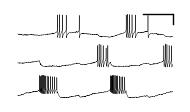

Num successful:  1
[[1.14197813e+03 1.83166667e+02 2.13105556e+02 3.63309375e+02
  1.60394199e-01 1.86610891e-01 3.18140398e-01 4.13044252e-01
  6.60575263e-01 4.71687500e+02 2.82675000e+02 2.84793750e+02
  7.07937500e+01 2.49386344e-01 6.19922120e-02 2.50000000e+00
  2.50000000e+00 2.50000000e+00 9.00000000e+00 9.00000000e+00
  8.00000000e+00 4.40000000e+01 7.80000000e+01 1.26000000e+02
  3.81710857e+03 8.29708268e+03 9.14013095e+03 4.15852583e+02
  8.87748358e+02 1.11073165e+03 8.50607556e+01 1.02432503e+02
  7.05226447e+01 1.00000000e+00]]
Energy consumption             PM           LP           PY
0  3817.108572  8297.082681  9140.130948
Energy consumption 2.1254322200251954


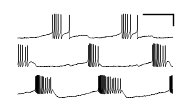

In [183]:
plot_stuff(selected_ones_1, "1")
plt.show()
print("====================")
plot_stuff(selected_ones_2, "2")
plt.show()

### Plot the different parameters of the 2

In [184]:
multipliers = [1.0, 100.0, 10.00, 10.0, 10.0, 1.0, 10000.0, 10000.0]
all_mult = multipliers * 3
all_mult += ([10_000_000] * 7)

In [185]:
def plot_params(selected_ones, params_to_plot, labels=True):
    samples, stats, all_seeds_loaded = load_theta_x_seeds(*selected_ones)
    close_sim = check_if_close_to_obs(stats, sloppiness_durations=allowed_std, sloppiness_phases=allowed_std)
    print("Num successful: ", np.sum(close_sim))
    
    successful_samples = samples[close_sim][0]
    print("successful_samples", successful_samples)

    with mpl.rc_context(fname='../../../.matplotlibrc'):
        fig, ax = plt.subplots(1, 1, figsize=(2., 1.))
        successful_samples[-7:] = np.exp(successful_samples[-7:])
        plotted_params = successful_samples[params_to_plot]
        plotted_params = plotted_params * np.asarray(all_mult)[params_to_plot]
        ax.bar(np.arange(len(params_to_plot)), plotted_params, color="k")
        if labels:
            ax.set_xticks(range(len(params_to_plot)))
            ax.set_xticklabels((np.asarray(labels_)[np.asarray(params_to_plot)]).tolist(), rotation=60)
        else:
            ax.set_xticks([])
        ax.set_ylim([0, 700.0])

In [186]:
labels_ = get_labels_8pt()

Num successful:  1
successful_samples [ 9.64380798e+01  4.52290535e-01  1.58520710e+00  1.04524975e+01
  4.26362371e+00  8.22476349e+01  8.85281898e-03  5.77116152e-03
  7.91645660e+01  2.23229155e-01  4.04225969e+00  2.12464561e+01
  5.94352436e+00  1.14620659e+02  3.14629786e-02  1.25897760e-02
  6.26683807e+01  1.95306754e+00  1.41108727e+00  3.18760853e+01
  2.57656015e-02  8.17412415e+01  5.66941462e-02  8.42853542e-03
 -1.55942602e+01 -1.17316589e+01 -1.16786861e+01 -9.75241947e+00
 -1.07426558e+01 -1.65105038e+01 -9.94432449e+00]


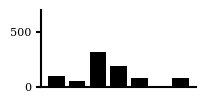

Num successful:  1
successful_samples [ 1.0719917e+02  3.4523133e-02  2.7700603e+00  1.3570135e+00
  8.7042370e+00  1.0331237e+02  3.2724093e-03  3.5023482e-03
  8.3634995e+01  1.6699423e-01  3.4527266e+00  1.9282070e+01
  5.6566820e+00  6.5824745e+01  4.3722715e-02  1.5971793e-02
  5.4687111e+01  1.2439693e+00  2.1207402e+00  3.2967701e+01
  1.4687725e+00  5.7959015e+01  2.9659744e-02  3.2956842e-03
 -1.0304170e+01 -1.1795620e+01 -1.6764637e+01 -1.0723309e+01
 -9.5170975e+00 -1.5435532e+01 -9.6006927e+00]


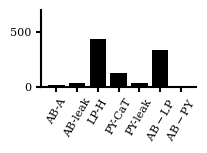

In [187]:
params_to_plot = [3, 7, 14, 17, 23, 24, 26]

plot_params(selected_ones_1, params_to_plot, labels=False)
plt.savefig(PANEL_NEW_C1, facecolor='None', transparent=True)
plt.show()
plot_params(selected_ones_2, params_to_plot)
plt.savefig(PANEL_NEW_C2, facecolor='None', transparent=True)
plt.show()

### Plot the energy bars for the 2 configurations

In [188]:
def plot_energies(selected_ones_1, labels=True):
    stats = load_x_pd(*selected_ones_1)
    close_sim = check_if_close_to_obs(stats.to_numpy(), sloppiness_durations=allowed_std, sloppiness_phases=allowed_std)
    successful_stats1 = stats[close_sim].iloc[0]
    
    energy1 = successful_stats1["energies"].to_numpy()/10/1000
    
    summed_energies_total1 = np.sum(np.asarray(energy1))
    
    with mpl.rc_context(fname='../../../.matplotlibrc'):
        fig, ax = plt.subplots(1, 1, figsize=(1, 0.8))
        ax.bar(range(4), [*energy1, summed_energies_total1], width=0.45, color=["#3182bd", "#fc8d59", "#2ca25f", "k"])
        ax.set_xticks(range(4))
        if labels:
            ax.set_xticklabels(["AB/PD", "LP", "PY", "Sum"], rotation=60)
            ax.set_xlabel("Energy cost")
        else:
            ax.set_xticks([])
        ax.set_ylim([0, 4.0])
        
    return summed_energies_total1

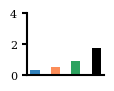

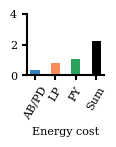

In [189]:
summed_energies_total1 = plot_energies(selected_ones_1, labels=False)
plt.savefig(PANEL_NEW_D1, facecolor='None', transparent=True)
summed_energies_total2 = plot_energies(selected_ones_2)
plt.savefig(PANEL_NEW_D2, facecolor='None', transparent=True)

### Plot the histogram of where the energies end up

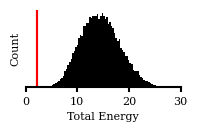

In [178]:
theta = pd.read_pickle("../../../results/simulation_data_Tube_MLslurm_cluster/close_to_xo_circuit_parameters.pkl")
x = pd.read_pickle("../../../results/simulation_data_Tube_MLslurm_cluster/close_to_xo_simulation_outputs.pkl")
seeds = np.load("../../../results/simulation_data_Tube_MLslurm_cluster/close_to_xo_seeds.npy")

theta_np = theta.to_numpy()
x_np = x.to_numpy()

all_total_energies = x["energies"].to_numpy()
summed_energies_total = np.sum(np.asarray(all_total_energies), axis=1)

with mpl.rc_context(fname="../../../.matplotlibrc"):
    fig, ax = plt.subplots(1, 1, figsize=(2.0, 1))
    _ = ax.hist(summed_energies_total/10/1000, range=[0, 30], bins=100, color="k")
    ax.axvline(summed_energies_total1, color="r")
    ax.axvline(summed_energies_total2, color="r")
    ax.set_ylabel('Count')
    ax.tick_params(axis="both", which="major")
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.axes.get_yaxis().set_ticks([])
    ax.set_xlabel("Total Energy")
    ax.set_xlim([0, 30])
    plt.savefig(PANEL_NEW_E, facecolor='None', transparent=True)

# Assemble figure

In [179]:
import time
import IPython.display as IPd

def svg(img):
    IPd.display(IPd.HTML('<img src="{}" / >'.format(img, time.time())))

In [180]:
from svgutils.compose import *

# > Inkscape pixel is 1/90 of an inch, other software usually uses 1/72.
# > http://www.inkscapeforum.com/viewtopic.php?f=6&t=5964
svg_scale = 1.25  # set this to 1.25 for Inkscape, 1.0 otherwise
factor_svg=5.5

# Panel letters in Helvetica Neue, 12pt, Medium
kwargs_text = {'size': '12pt', 'font': 'Arial', 'weight': '800'}
kwargs_consistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_consistent1 = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#9E7DD5'}
kwargs_inconsistent = {'size': '10pt', 'font': 'Arial', 'weight': '500', 'color': '#AF99EF'}
kwargs_text8pt = {'size': '7.7pt', 'font': 'Arial'}

sizefactor = 1.0
dshift = 0.5*factor_svg

f = Figure("20.3cm", "12.5cm",
    
    Panel(
          SVG(PANEL_NEW_A).scale(svg_scale*1.03).move(0*factor_svg, 0*factor_svg),
          Text("a", 0*factor_svg, 2.0*factor_svg-dshift, **kwargs_text),
    ).move(0*factor_svg, 0*factor_svg+dshift),

    Panel(
        SVG(PANEL_NEW_F1).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
        Text("b", 3.0*factor_svg, 3.7*factor_svg-dshift, **kwargs_text),
    ).move(38.0*factor_svg, 0-1.5*factor_svg+dshift),
           
    Panel(
        SVG(PANEL_NEW_F2).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
    ).move(38.0*factor_svg, 100-1.5*factor_svg+dshift),
    
    Panel(
        SVG(PANEL_NEW_G1).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
        Text("c", -4.0*factor_svg, 1.5*factor_svg-dshift, **kwargs_text),
    ).move(79.0*factor_svg, 1.3*factor_svg+dshift),
           
    Panel(
        SVG(PANEL_NEW_G2).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
    ).move(79.0*factor_svg, 100-1.5*factor_svg+dshift),
           
    Panel(
        SVG("../svg/panel_d_for_new.svg").scale(svg_scale).move(0*factor_svg, 0*factor_svg),
        Text("d", -2.0*factor_svg, 2.5*factor_svg-dshift, **kwargs_text),
    ).move(101.5*factor_svg, 10-1.5*factor_svg+dshift),
                      
    Panel(
          SVG(PANEL_NEW_E).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
          Text("e", -4*factor_svg, 3.5*factor_svg-dshift, **kwargs_text),
    ).move(4*factor_svg, 43.0*factor_svg),
       
    Panel(
          SVG(PANEL_NEW_supp_c).scale(svg_scale).move(-10*factor_svg,0*factor_svg),
          Text("f", -14*factor_svg, 1.5*factor_svg-dshift, **kwargs_text),
    ).move(14*factor_svg, 63.5*factor_svg),
           
    Panel(
        SVG(PANEL_NEW_B1).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
        Text("g", 0.0*factor_svg, 3.5*factor_svg-dshift, **kwargs_text),
    ).move(41.0*factor_svg, 240-1.5*factor_svg+dshift),
    
    Panel(
        SVG(PANEL_NEW_B2).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
    ).move(41.0*factor_svg, 340-1.5*factor_svg+dshift),
           
    Panel(
        SVG(PANEL_NEW_D1).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
        Text("h", -4.0*factor_svg, 0.5*factor_svg-dshift, **kwargs_text),
    ).move(79.0*factor_svg, 240+1.0*factor_svg+dshift),
           
    Panel(
        SVG(PANEL_NEW_D2).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
    ).move(79.0*factor_svg, 340-1.5*factor_svg+dshift),
    
    Panel(
        SVG(PANEL_NEW_C1).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
        Text("i", -2.0*factor_svg, 3.5*factor_svg-dshift, **kwargs_text),
    ).move(105.0*factor_svg, 240-1.5*factor_svg+dshift),

    Panel(
        SVG(PANEL_NEW_C2).scale(svg_scale).move(0*factor_svg, 0*factor_svg),
    ).move(105.0*factor_svg, 340-1.5*factor_svg+dshift),
)

!mkdir -p fig
f.save("../fig/fig3_new.svg")
svg('../fig/fig3_new.svg')